# Image alignment

Objetivo alinhar as imagens obtidas nas 4 faixas espectrais para obter uma imagem de 4 canais que representa o objeto e pode ser visualizada como uma imagem de falsa-cor.

![image info](./alignment-visualization.png)

a ideia inicial é usar os [descriptores](https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html).



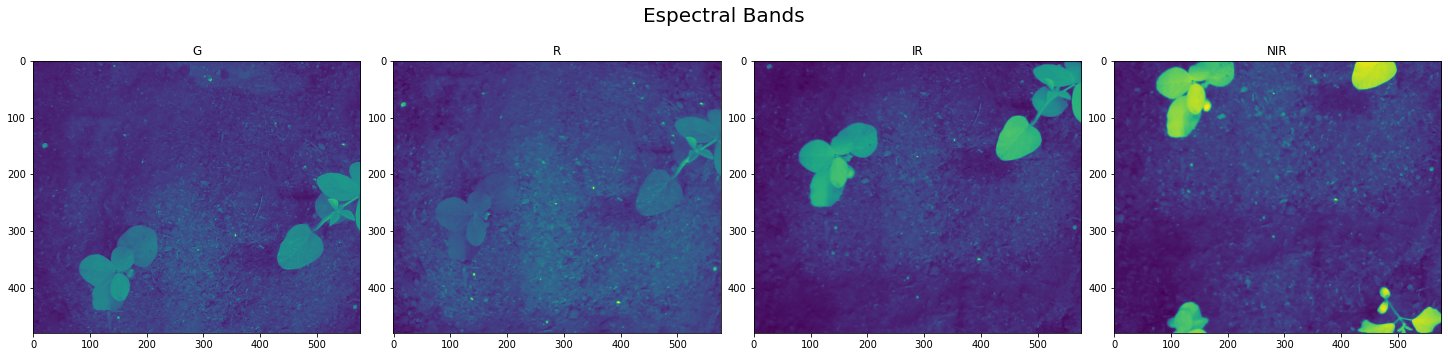

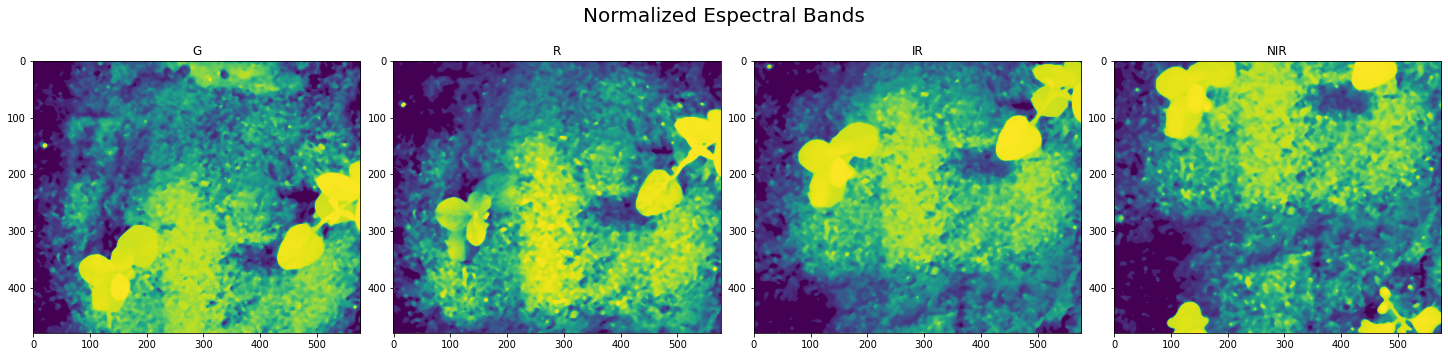

In [1]:
import cv2
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

G   = cv2.imread("imgs/Soja_v3G-01-03.png",  0) 
R   = cv2.imread("imgs/Soja_v3R-01-03.png",  0)
NIR  = cv2.imread("imgs/Soja_v3IR-01-03.png", 0)
IR = cv2.imread("imgs/Soja_v3NIR-01-03.png",0)
RGB = cv2.imread("imgs/Soja_v3RGB-01-03.png")

bands = [G,R,IR,NIR]
names = ["G","R","IR","NIR"]
# Visualização das imagens
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands", fontsize = 20)
for (img, ax, name) in zip(bands, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

# A normalização das imagens facilita a comparação entre as imagens destacando as plantas do backgroud
def equalize_smooth(img):
    """ Histogram Normalization and gaussian blur of input image """
    # img_blur = cv2.GaussianBlur(img, (3,3),0)
    img_blur = cv2.medianBlur(img, 7)
    img_norm = cv2.equalizeHist(img_blur)
    ret, img_norm = cv2.threshold(img_norm, 20, 255, cv2.THRESH_TOZERO)
    return img_norm

# Visualização das imagens normalizadas
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Normalized Espectral Bands", fontsize = 20)
for (img, ax, name) in zip(bands, axs, names):
    img = equalize_smooth(img)
    ax.imshow(img)
    ax.set_title(name)

# RGB image for reference
# plt.show()
# plt.imshow(RGB)
# plt.title("RGB")
# plt.show()



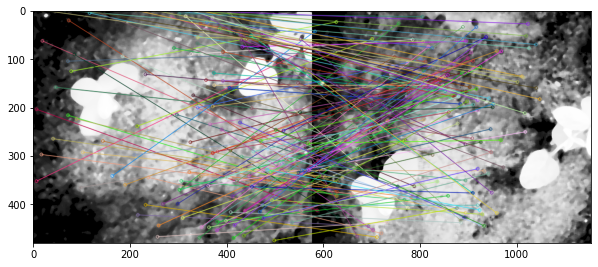

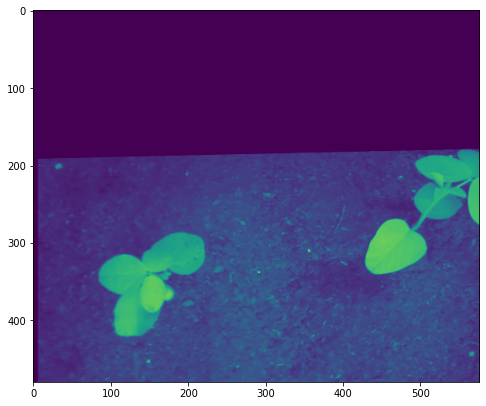

In [2]:


# Selecionar as imagens que vão ser alinhadas:
def stitch_SIFT(img_original, base, visualize = True):

    if (len(base.shape) > 2):
        gray = cv2.cvtColor(base, cv2.COLOR_BGR2GRAY)
    else:
        gray = base
        
    img =  equalize_smooth(img_original)
    gray = equalize_smooth(base)   

    # Seleção dos descriptors:
    descriptor = cv2.SIFT.create()
    # descriptor = cv2.xfeatures2d.SURF_create() #O SURF não é um algoritmo open source e só é incluido no opencv-contrib-python use com cautela.
    matcher = cv2.FlannBasedMatcher()

    # get features from images
    kps_img, desc_img = descriptor.detectAndCompute(img, mask=None)

        
    kps_base, desc_base = descriptor.detectAndCompute(gray, mask=None)

    # find the corresponding point pairs
    if (desc_img is not None and desc_base is not None and len(desc_img) >=2 and len(desc_base) >= 2):
        rawMatch = matcher.knnMatch(desc_base, desc_img, k=2)

    matches = []
    # ensure the distance is within a certain ratio of each other (i.e. Lowe's ratio test)
    ratio = 0.75
    for m in rawMatch:
        if len(m) == 2 and m[0].distance < m[1].distance * ratio:
            matches.append((m[0].trainIdx, m[0].queryIdx))
            # print("Train index: ", m[0].trainIdx, "\n Query index", m[0].queryIdx)
            # print()
            
    if visualize:
        # Apply ratio test
        good = []
        for m,n in rawMatch:
            if m.distance < 0.75*n.distance:
                good.append([m])
        img3 = cv2.drawMatchesKnn(img,kps_img,gray,kps_base,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        fig, ax = plt.subplots( figsize = (10,5))
        ax.imshow(img3)
        plt.show()
        

    # convert keypoints to points
    pts_img, pts_base = [], []
    for id_img, id_base in matches:
        pts_img.append(kps_img[id_img].pt)
        pts_base.append(kps_base[id_base].pt)
    pts_img = np.array(pts_img, dtype=np.float32)
    pts_base = np.array(pts_base, dtype=np.float32)

    # compute homography
    if len(matches) > 4:
    #     H, status = cv2.findHomography(pts_img, pts_base, cv2.RANSAC)
        H, _ = cv2.estimateAffine2D(pts_img, pts_base)
        H = np.vstack((H, [0, 0, 1]))
        # print("H = ", H)
    warped = cv2.warpPerspective(img_original, H, (base.shape[1], base.shape[0]))
    return warped

base = G
# warped = stitch_SIFT(R, base)
warped = stitch_SIFT(IR, base)
plt.imshow(warped)


In [3]:
# visualize the result
winname = 'result'
cv2.namedWindow(winname, cv2.WINDOW_KEEPRATIO)
alpha = 5
# res = cv2.addWeighted(base, 0.5, warped, 0.5, 0)
res = None
def onChange(alpha):
    global base, warped, res, winname
    res = cv2.addWeighted(base, alpha/5, warped, 1 - alpha/5, 0)
    cv2.imshow(winname, res)
    cv2.imwrite("alignmentR"+ str(alpha) + ".png",res) # Salva as imagens mostradas pelo trackbar

onChange(alpha)
cv2.createTrackbar('alpha', winname, alpha, 5, onChange)
cv2.imshow(winname, res)

cv2.waitKey()
cv2.destroyAllWindows()

480 577 577 480
480 577 577 480
480 577 577 480
480 577 577 480


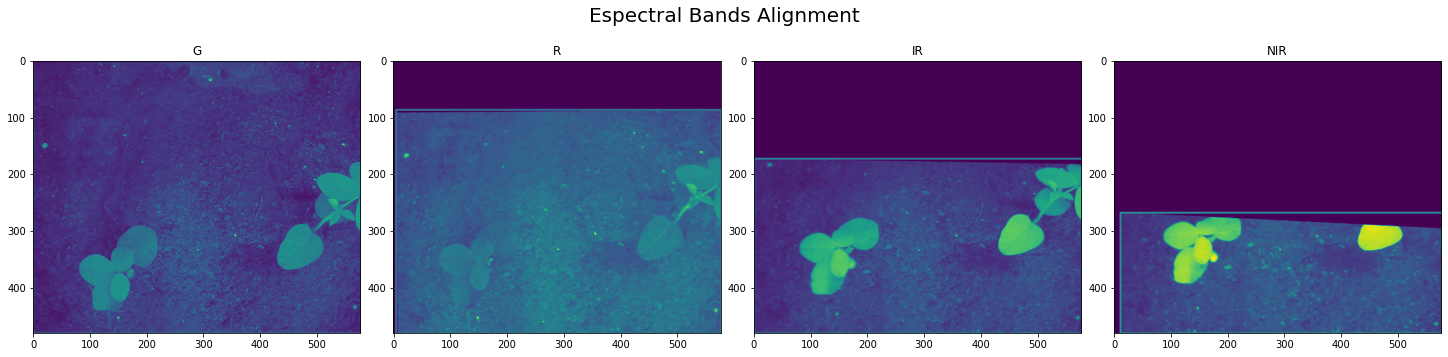

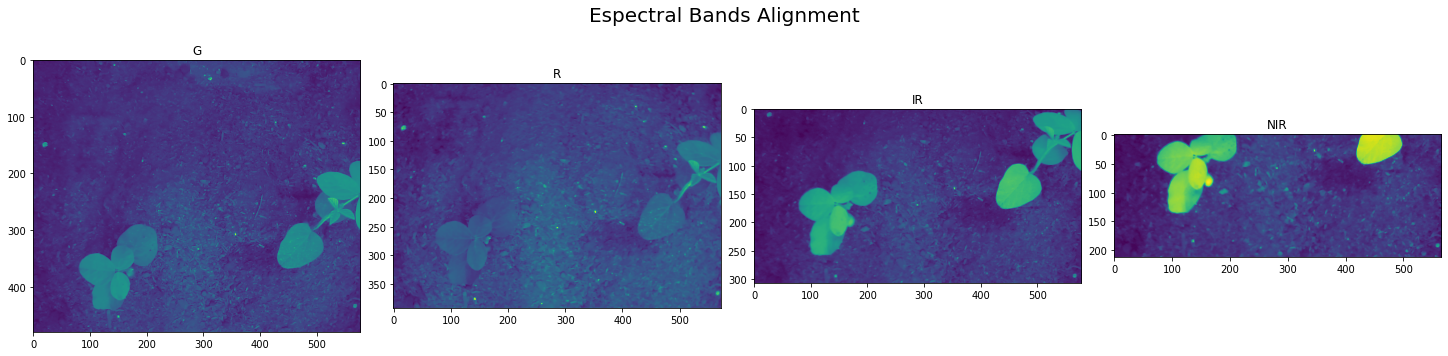

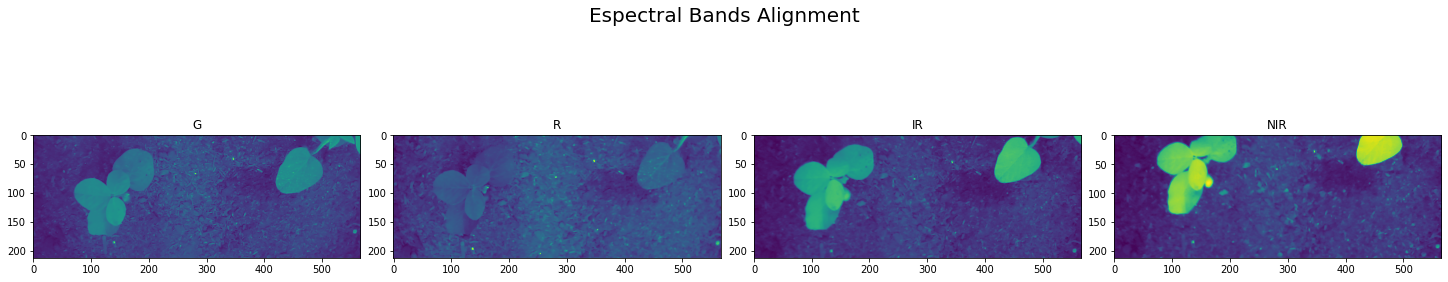

In [4]:
# Visualização da sobreposição para cada banda
base = G
bands_dict = dict()
spectral_img = []
fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands Alignment", fontsize = 20)

for (img, ax, name) in zip(bands, axs, names):
    warped = stitch_SIFT(img,base, False)
    bands_dict[name] = warped 
    
    ax.set_title(name)
    x, y, w, h  = cv2.boundingRect(cv2.findNonZero(warped))
    warped = cv2.rectangle(warped, (x,y), (warped.shape[1],warped.shape[0]), (100,100,100), 2)
    print(warped.shape[0], warped.shape[1], x+w, y+h)
    ax.imshow(warped)
    rect = img[:h, :w] 
    spectral_img.append(rect)
plt.show()

fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands Alignment", fontsize = 20)
for (img, ax, name) in zip(spectral_img, axs, names):
    ax.imshow(img)
    ax.set_title(name)
plt.show()

fig, axs = plt.subplots( 1,len(bands), constrained_layout = True, figsize = (len(bands)*5, 5))
fig.suptitle("Espectral Bands Alignment", fontsize = 20)

spectral_dict = dict()
x, y, w, h  = cv2.boundingRect(cv2.findNonZero(bands_dict["NIR"]))
for (img, ax, name) in zip(spectral_img, axs, names):
    ax.imshow(img[-h:, -w:] )
    spectral_dict[name] = img[-h:, -w:]
    ax.set_title(name)
#     print(x, y, w, h)
plt.show()



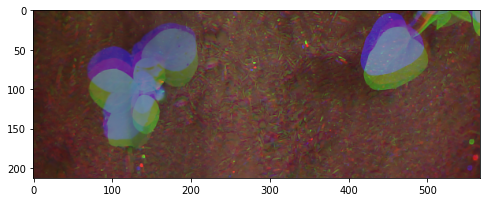

In [5]:
merged = cv2.merge([spectral_dict["R"], spectral_dict["G"], spectral_dict["IR"]])
plt.imshow(merged)
plt.show()


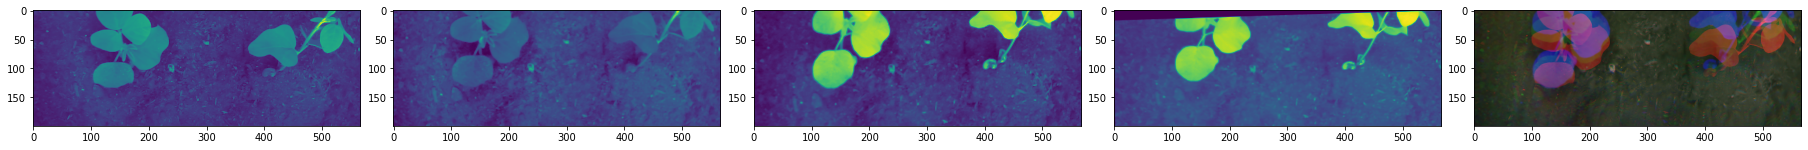

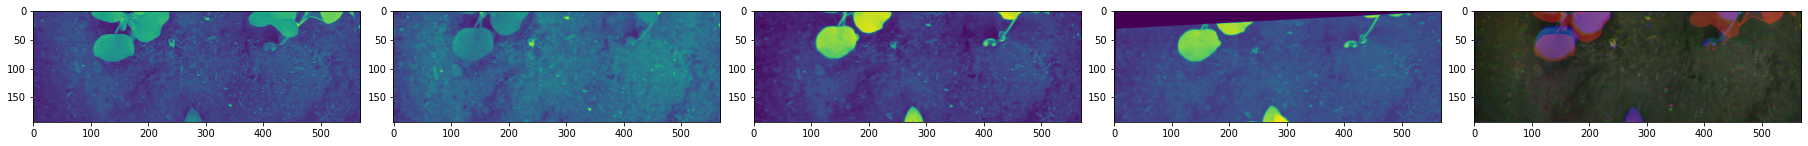

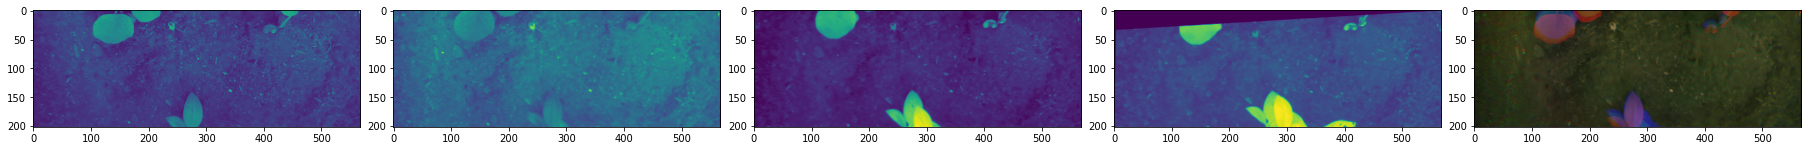

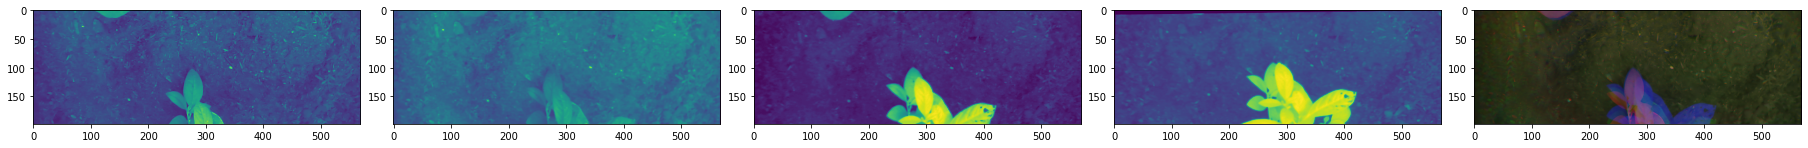

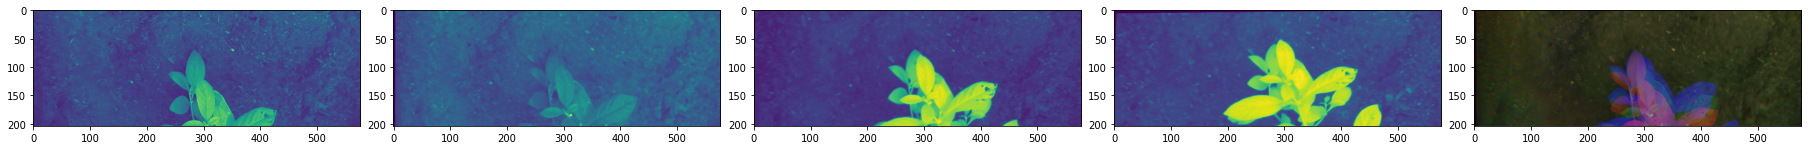

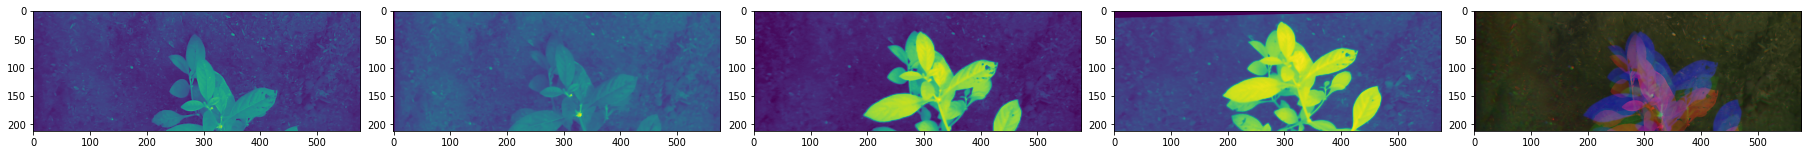

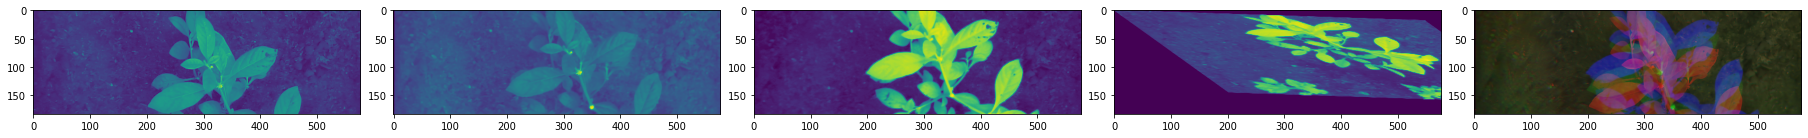

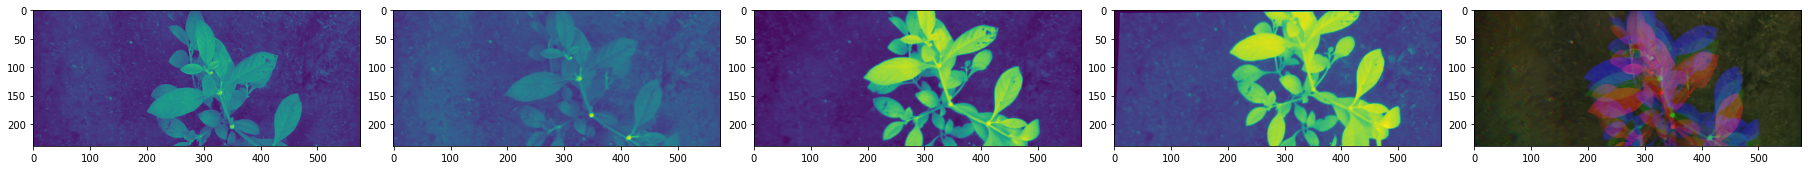

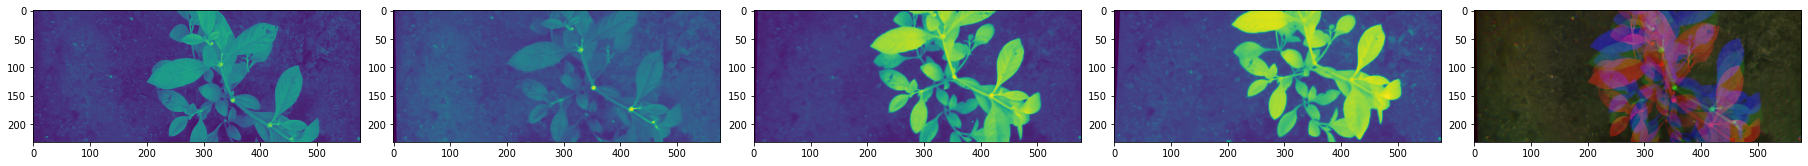

In [6]:
def align(G, R, IR, NIR):
    for (g, r, ir,nir) in zip(G, R, IR, NIR):
        
        base = g
        
        r_stitch = stitch_SIFT(r,base, False)
        ir_stitch = stitch_SIFT(ir,base, False)
        nir_stitch = stitch_SIFT(nir,base, False)
        
        x, y, w, h  = cv2.boundingRect(cv2.findNonZero(nir_stitch))
        
        g_stitch = g[y:base.shape[0], x:base.shape[1]]
        r_stitch = r_stitch[y:base.shape[0], x:base.shape[1]]
        ir_stitch = ir_stitch[y:base.shape[0], x:base.shape[1]]
        nir_stitch = nir_stitch[y:base.shape[0], x:base.shape[1]]


#         g_stitch = cv2.rectangle(g, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
#         r_stitch = cv2.rectangle(r_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
#         ir_stitch = cv2.rectangle(ir_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
#         nir_stitch = cv2.rectangle(nir_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
        
        fig, axs = plt.subplots( 1,len(bands)+1, constrained_layout = True, figsize = ((len(bands)+1)*5, 5))
        axs[0].imshow(g_stitch)
        axs[1].imshow(r_stitch)
        axs[2].imshow(ir_stitch)
        axs[3].imshow(nir_stitch)
        
        merged = cv2.merge([g_stitch, r_stitch, ir_stitch])
        axs[4].imshow(merged)
        plt.show()
                
path = "imgs/samples-24-nov/"
bands = ["G","R", "IR", "NIR"]
Gs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"G"+"-01-01"+str(i)+".png", 0) for i in range(9)]
Rs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"R"+"-01-01"+str(i)+".png", 0) for i in range(9)]
IRs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"NIR"+"-01-01"+str(i)+".png", 0) for i in range(9)]
NIRs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"IR"+"-01-01"+str(i)+".png", 0) for i in range(9)] #ir and nir swapped

align(Gs, Rs, IRs, NIRs)
        

Using Enhanced Correlation Coefficient (ECC)
---

[2D Transforms](https://www.learnopencv.com/image-alignment-ecc-in-opencv-c-python/)

- Use Enhanced Correlation Coefficient (ECC) algorithm to perform image alignment using the euclidean model between images 2 and 1;
- The returned transformation matrix is then used to transform image 1 with the help of cv2.warpAffine() and calculate the approximate rectangular area of the transformation in image 1;
- Repeat the same steps to transform image 3: use Enhanced Correlation Coefficient (ECC) algorithm to perform image alignment using the euclidean model between images 2 and 3;
- The returned transformation matrix is then used to transform image 3 with the help of cv2.warpAffine() and calculate the approximate rectangular area of the transformation.


In [ ]:
def get_gradient(im) :
    # Calculate the x and y gradients using Sobel operator
    grad_x = cv2.Sobel(im,cv2.CV_32F,1,0,ksize=3)
    grad_y = cv2.Sobel(im,cv2.CV_32F,0,1,ksize=3)

    # Combine the two gradients
    grad = cv2.addWeighted(np.absolute(grad_x), 0.5, np.absolute(grad_y), 0.5, 0)
    return grad


def stitch_ECC(im2, im1, mode = cv2.MOTION_TRANSLATION):
    """ Align images using ECC. Modes: cv2.MOTION_TRANSLATION || cv2.MOTION_HOMOGRAPHY """

    im1_gray =  equalize_smooth(im1)
    im2_gray = equalize_smooth(im2)   

    # Convert images to grayscale
    # im1_gray = cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)
    # im2_gray = cv2.cvtColor(im2,cv2.COLOR_BGR2GRAY)


    # Find size of image1
    sz = im1.shape

    # Define the motion model
    warp_mode =  mode #cv2.MOTION_TRANSLATION || cv2.MOTION_HOMOGRAPHY

    # Define 2x3 or 3x3 matrices and initialize the matrix to identity
    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        warp_matrix = np.eye(3, 3, dtype=np.float32)
    else :
        warp_matrix = np.eye(2, 3, dtype=np.float32)

    # Specify the number of iterations.
    number_of_iterations = 5000;

    # Specify the threshold of the increment
    # in the correlation coefficient between two iterations
    termination_eps = 1e-10;

    # Define termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

    # Run the ECC algorithm. The results are stored in warp_matrix.
    (cc, warp_matrix) = cv2.findTransformECC (get_gradient(im1_gray),get_gradient(im2_gray),warp_matrix, warp_mode, criteria)

    if warp_mode == cv2.MOTION_HOMOGRAPHY :
        # Use warpPerspective for Homography
        im2_aligned = cv2.warpPerspective (im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    else :
        # Use warpAffine for Translation, Euclidean and Affine
        im2_aligned = cv2.warpAffine(im2, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);
    return im2_aligned

base = G
warped = stitch_ECC(IR, base)
plt.imshow(warped)
plt.show()
warped = stitch_ECC(IR, base, cv2.MOTION_HOMOGRAPHY)
plt.imshow(warped)
plt.show()

In [31]:
# visualize the result
winname = 'result'
cv2.namedWindow(winname, cv2.WINDOW_KEEPRATIO)
alpha = 5
# res = cv2.addWeighted(base, 0.5, warped, 0.5, 0)
res = None
def onChange(alpha):
    global base, warped, res, winname
    res = cv2.addWeighted(base, alpha/5, warped, 1 - alpha/5, 0)
    cv2.imshow(winname, res)
    cv2.imwrite("alignmentR"+ str(alpha) + ".png",res) # Salva as imagens mostradas pelo trackbar

onChange(alpha)
cv2.createTrackbar('alpha', winname, alpha, 5, onChange)
cv2.imshow(winname, res)

cv2.waitKey()
cv2.destroyAllWindows()

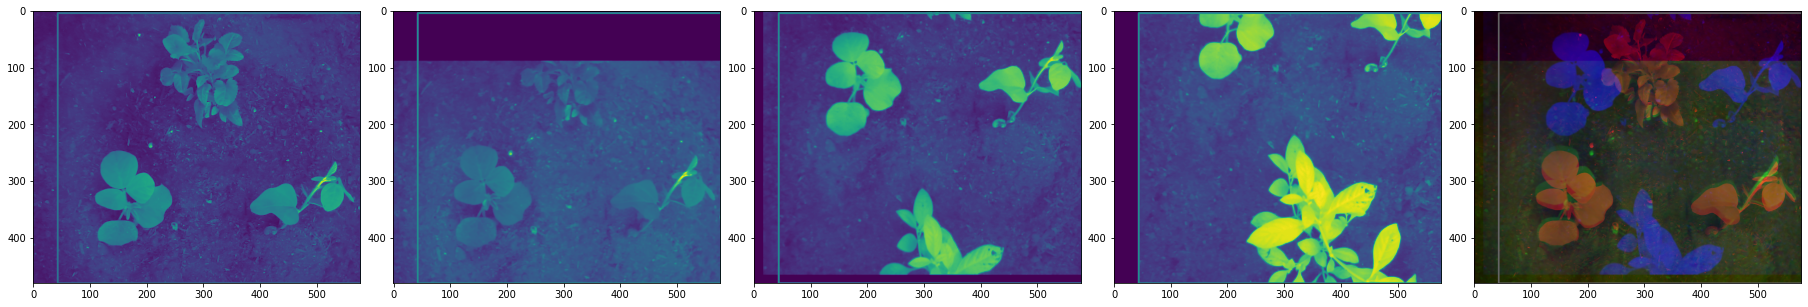

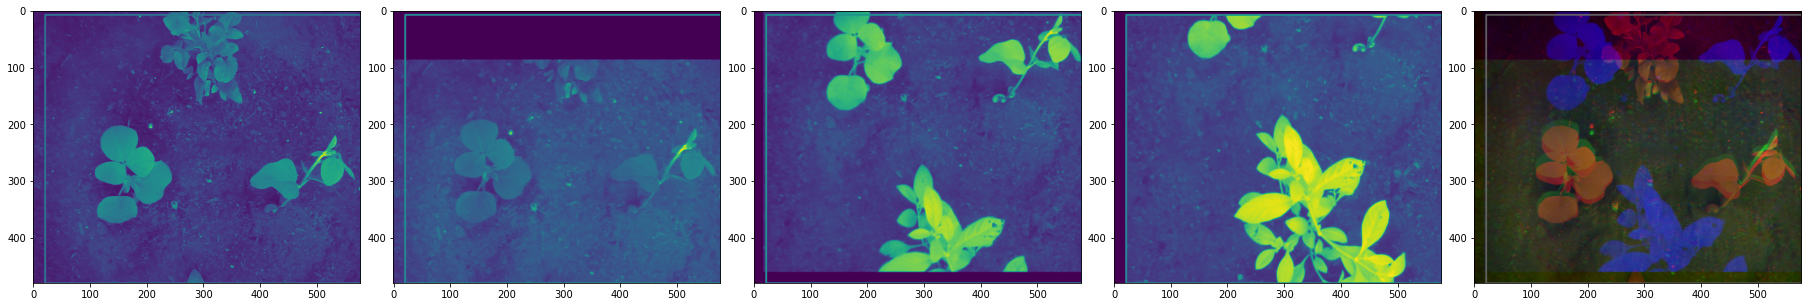

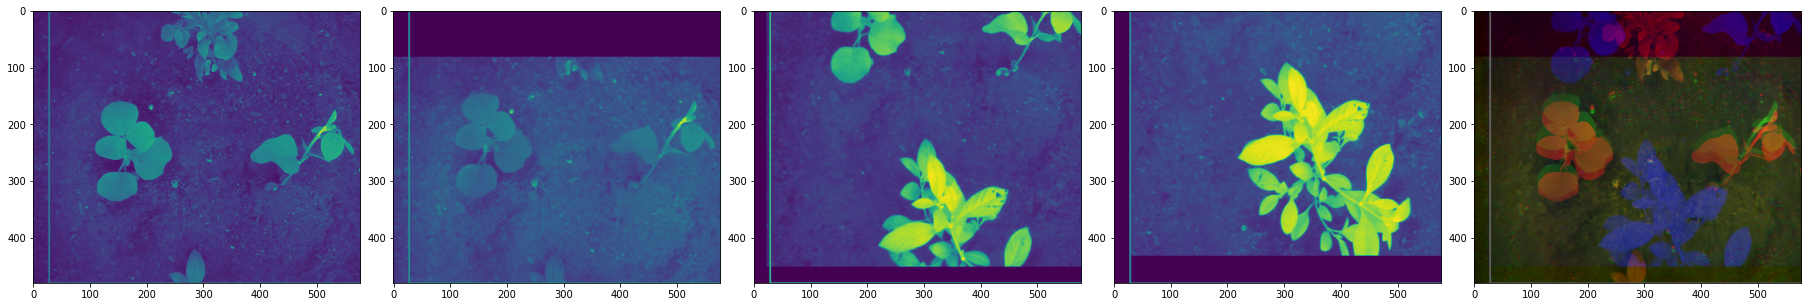

In [13]:
def align(G, R, IR, NIR):
    for (g, r, ir,nir) in zip(G, R, IR, NIR):
        
        base = g
        
        r_stitch = stitch_ECC(r,base)
        ir_stitch = stitch_ECC(ir,base)
        nir_stitch = stitch_ECC(nir,base)
        
        x, y, w, h  = cv2.boundingRect(cv2.findNonZero(nir_stitch))
        
#         g_stitch = g[y:base.shape[0], x:base.shape[1]]
#         r_stitch = r_stitch[y:base.shape[0], x:base.shape[1]]
#         ir_stitch = ir_stitch[y:base.shape[0], x:base.shape[1]]
#         nir_stitch = nir_stitch[y:base.shape[0], x:base.shape[1]]


        g_stitch = cv2.rectangle(g, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
        r_stitch = cv2.rectangle(r_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
        ir_stitch = cv2.rectangle(ir_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
        nir_stitch = cv2.rectangle(nir_stitch, (x,y), (base.shape[1],base.shape[0]), (100,100,100), 2)
        
        fig, axs = plt.subplots( 1,len(bands)+1, constrained_layout = True, figsize = ((len(bands)+1)*5, 5))
        axs[0].imshow(g_stitch)
        axs[1].imshow(r_stitch)
        axs[2].imshow(ir_stitch)
        axs[3].imshow(nir_stitch)
        
        merged = cv2.merge([g_stitch, r_stitch, ir_stitch])
        axs[4].imshow(merged)
        cv2.imwrite("spectral.png", merged)
        plt.show()
                
path = "imgs/samples-24-nov/"
bands = ["G","R", "IR", "NIR"]
n = 3
Gs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"G"+"-01-01"+str(i)+".png", 0) for i in range(n)]
Rs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"R"+"-01-01"+str(i)+".png", 0) for i in range(n)]
IRs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"NIR"+"-01-01"+str(i)+".png", 0) for i in range(n)]
NIRs = [cv2.imread(path+"Soja_v3_PlantasDiversas_Teste"+"IR"+"-01-01"+str(i)+".png", 0) for i in range(n)] #ir and nir swapped

align(Gs, Rs, IRs, NIRs)